# <span style='color:blue'>종합실습 2</span>
- OO공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다. 그 원인을 분석해 본 결과 **압연공정**에서 scale 불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as statsmodels
import graphviz
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from scipy import stats
import scipy.stats
from scipy.stats import shapiro

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.api import Logit

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

matplotlib.rc("font", family = "NanumGothic")
matplotlib.rc('axes', unicode_minus=False)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 데이터 불러오기

In [2]:
df_raw = pd.read_csv('SCALE불량.csv', encoding = 'euc-kr')
df_raw['SCALE'].replace('양품',0,inplace=True)
df_raw['SCALE'].replace('불량',1,inplace=True)
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873,적용,8,1조


In [3]:
df_raw.describe()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.320833,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.204167,1149.666667,75.330556,300.563889,1139.570833,933.920833,8.319444
std,0.467121,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,36.248696,17.571788,26.086390,45.390303,17.857121,107.863887,1.623252
min,0.000000,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1102.000000,0.000000,5.000000
25%,0.000000,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1122.750000,889.750000,6.000000
50%,0.000000,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1144.000000,951.000000,8.000000
75%,1.000000,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,85.250000,342.000000,1154.000000,994.250000,10.000000
max,1.000000,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,251.000000,1185.000000,194.000000,398.000000,1175.000000,1078.000000,10.000000


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    int64  
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

## 결측치 확인 및 제거

- 주어진 데이터에서의 결측치는 존재X

In [5]:
df_raw.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

## 이상치 확인

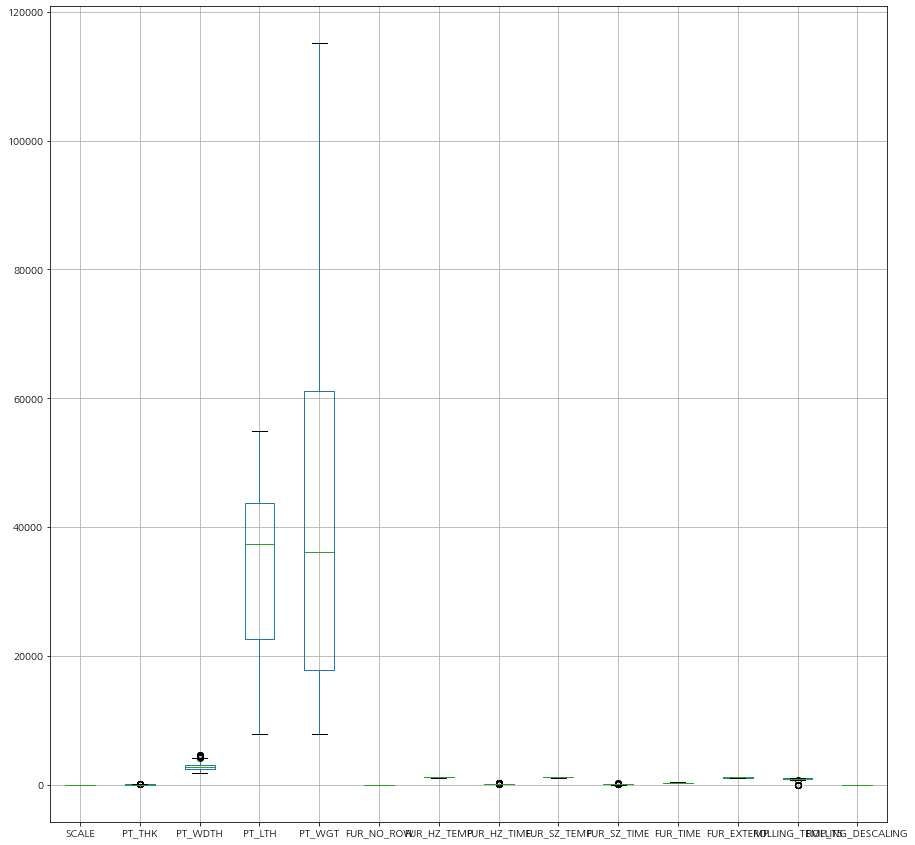

In [6]:
df_raw.boxplot(figsize=(15,15))
plt.show()

In [7]:
df_raw['ROLLING_TEMP_T5'] = df_raw['ROLLING_TEMP_T5'].replace(0, df_raw['ROLLING_TEMP_T5'].mean()) 

### 이상치 확인 결과
- 다양한 변수들에서 이상치로 보이는 요소들이 확인은 되었으나, 이상치라고 판단하기에는 정보가 부족하여 대체하지 않고 넘어가도록 한다.
- 하지만 압연공정에서의 온도를 뜻하는 "ROLLING_TEMP_T5" 변수에 0의 값이 들어있는 것은 결과에 영향을 미칠 수 있기에 평균으로 대체한다.

## 탐색적 분석
- 그래프를 통해 영향인자를 예측해보기

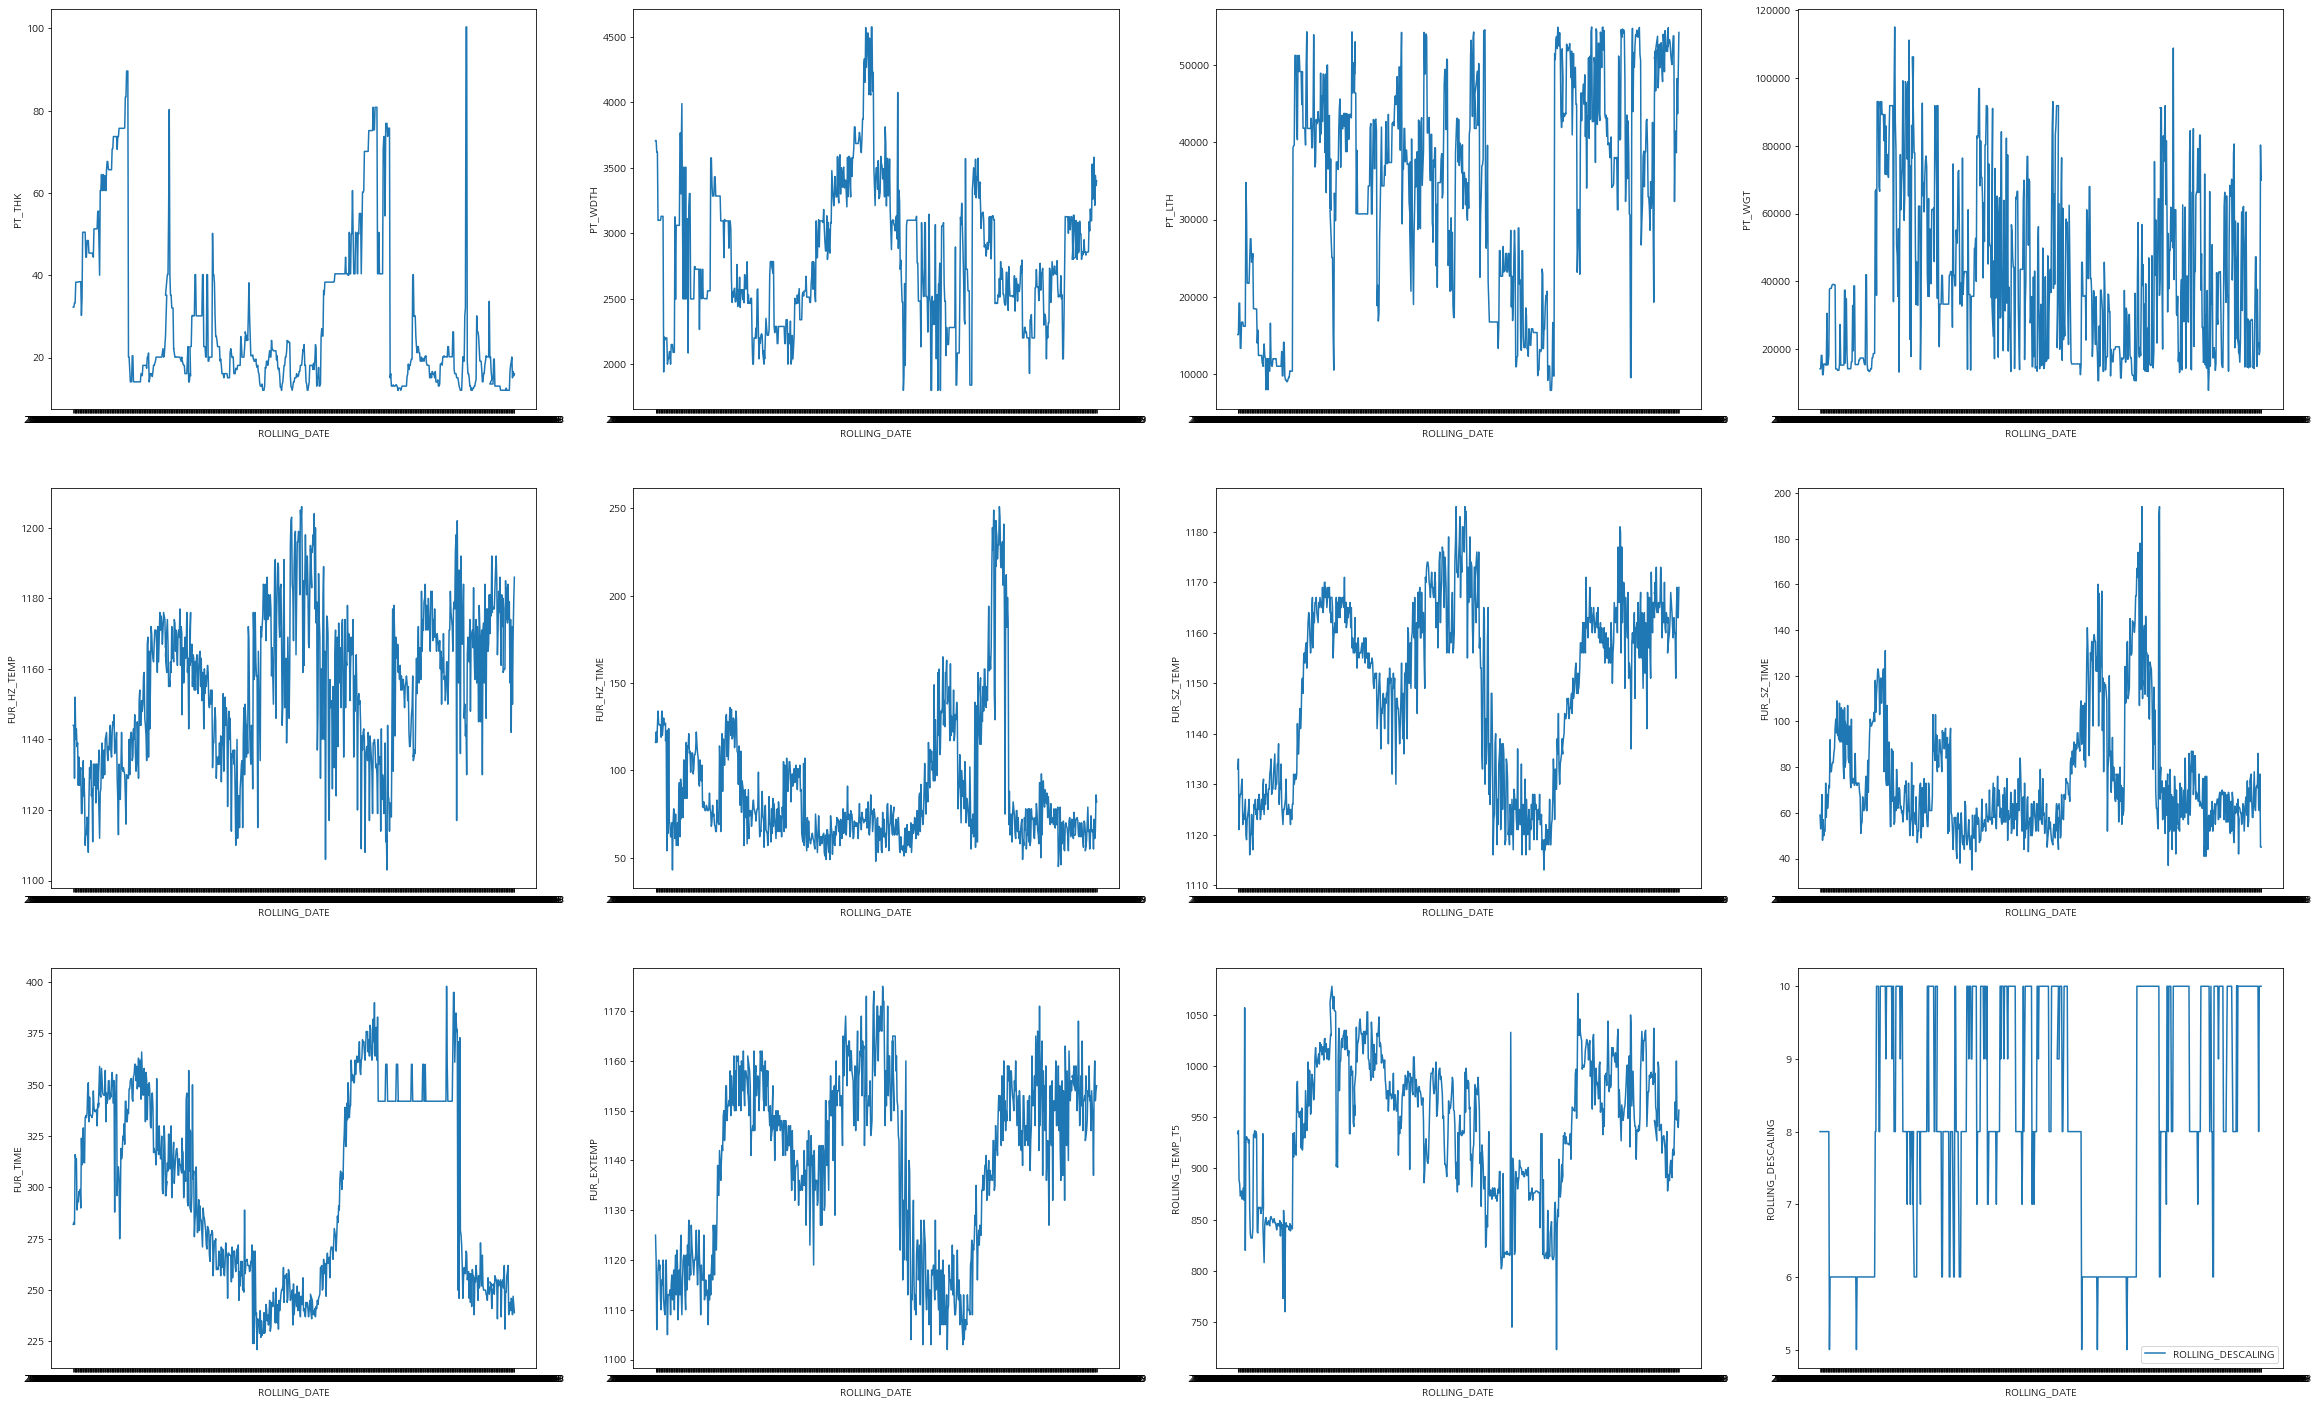

In [8]:
# 시간별 데이터 분포
fig = plt.figure(figsize=(40,25))

# 시간별 PT_THK 분포
plt.subplot(3,4,1)
plt.plot(df_raw["ROLLING_DATE"], df_raw["PT_THK"], label = "PT_THK")
plt.ylabel("PT_THK"); plt.xlabel("ROLLING_DATE")

# 시간별 PT_WDTH 분포
plt.subplot(3,4,2)
plt.plot(df_raw["ROLLING_DATE"], df_raw["PT_WDTH"], label = "PT_WDTH")
plt.ylabel("PT_WDTH"); plt.xlabel("ROLLING_DATE")

# 시간별 PT_LTH 분포
plt.subplot(3,4,3)
plt.plot(df_raw["ROLLING_DATE"], df_raw["PT_LTH"], label = "PT_LTH")
plt.ylabel("PT_LTH"); plt.xlabel("ROLLING_DATE")

# 시간별 PT_WGT 분포
plt.subplot(3,4,4)
plt.plot(df_raw["ROLLING_DATE"], df_raw["PT_WGT"], label = "PT_WGT")
plt.ylabel("PT_WGT"); plt.xlabel("ROLLING_DATE")

# 시간별 FUR_HZ_TEMP 분포
plt.subplot(3,4,5)
plt.plot(df_raw["ROLLING_DATE"], df_raw["FUR_HZ_TEMP"], label = "FUR_HZ_TEMP")
plt.ylabel("FUR_HZ_TEMP"); plt.xlabel("ROLLING_DATE")

# 시간별 FUR_HZ_TIME 분포
plt.subplot(3,4,6)
plt.plot(df_raw["ROLLING_DATE"], df_raw["FUR_HZ_TIME"], label = "FUR_HZ_TIME")
plt.ylabel("FUR_HZ_TIME"); plt.xlabel("ROLLING_DATE")

# 시간별 FUR_SZ_TEMP 분포
plt.subplot(3,4,7)
plt.plot(df_raw["ROLLING_DATE"], df_raw["FUR_SZ_TEMP"], label = "FUR_SZ_TEMP")
plt.ylabel("FUR_SZ_TEMP"); plt.xlabel("ROLLING_DATE")

# 시간별 FUR_SZ_TIME 분포
plt.subplot(3,4,8)
plt.plot(df_raw["ROLLING_DATE"], df_raw["FUR_SZ_TIME"], label = "FUR_SZ_TIME")
plt.ylabel("FUR_SZ_TIME"); plt.xlabel("ROLLING_DATE")

# 시간별 FUR_TIME 분포
plt.subplot(3,4,9)
plt.plot(df_raw["ROLLING_DATE"], df_raw["FUR_TIME"], label = "FUR_TIME")
plt.ylabel("FUR_TIME"); plt.xlabel("ROLLING_DATE")

# 시간별 FUR_EXTEMP 분포
plt.subplot(3,4,10)
plt.plot(df_raw["ROLLING_DATE"], df_raw["FUR_EXTEMP"], label = "FUR_EXTEMP")
plt.ylabel("FUR_EXTEMP"); plt.xlabel("ROLLING_DATE")

# 시간별 ROLLING_TEMP_T5 분포
plt.subplot(3,4,11)
plt.plot(df_raw["ROLLING_DATE"], df_raw["ROLLING_TEMP_T5"], label = "ROLLING_TEMP_T5")
plt.ylabel("ROLLING_TEMP_T5"); plt.xlabel("ROLLING_DATE")

# 시간별 ROLLING_DESCALING 분포
plt.subplot(3,4,12)
plt.plot(df_raw["ROLLING_DATE"], df_raw["ROLLING_DESCALING"], label = "ROLLING_DESCALING")
plt.ylabel("ROLLING_DESCALING"); plt.xlabel("ROLLING_DATE")

plt.legend(loc = "best")
plt.show()

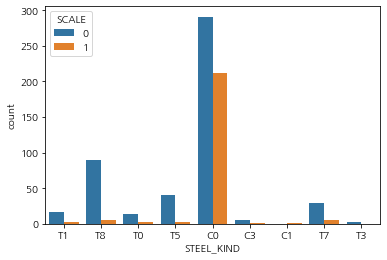

In [9]:
sns.countplot(data = df_raw, x = df_raw['STEEL_KIND'], hue = df_raw['SCALE'])
plt.show()

**T3은 양품뿐, C0의 데이터 수가 월등히 많다.**

<AxesSubplot:>

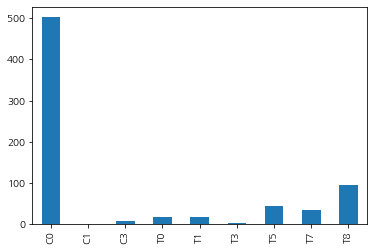

In [10]:
df_cnt = df_raw["STEEL_KIND"].value_counts()
df_cnt.sort_index(inplace = True)
df_cnt.plot.bar()

**애초에 C0의 데이터의 수가 월등히 많음**

In [11]:
df_raw[df_raw["STEEL_KIND"] == "T3"]

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
408,PB563182,2008-08-01:19:90:28,0,API-2W-50T,T3,25.23,2616,30128,62440,2호기,...,1151,63,1138,69,250,1128,854.0,적용,8,4조
409,PB563183,2008-08-01:19:90:54,0,API-2W-50T,T3,25.23,1990,39606,46830,3호기,...,1180,67,1159,65,251,1145,843.0,적용,8,1조


In [12]:
df_raw[df_raw["STEEL_KIND"] == "C1"]

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
169,PB562943,2008-08-01:09:90:57,1,JS-SS400,C1,20.18,2240,36748,65200,1호기,...,1171,99,1167,54,318,1156,1005.0,적용,8,4조


**C0의 불량률이 높았던 것은 데이터의 수의 차이가 있기에**

**HSB의 여부에 따라 양품판정 비율도 변화, 일단은 연관있군**

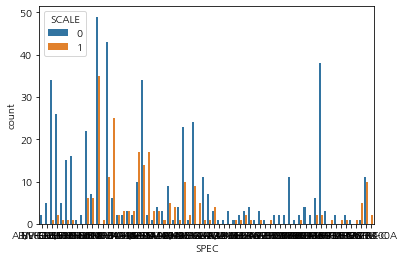

In [13]:
sns.countplot(data = df_raw, x = df_raw['SPEC'], hue = df_raw['SCALE'])
plt.show()

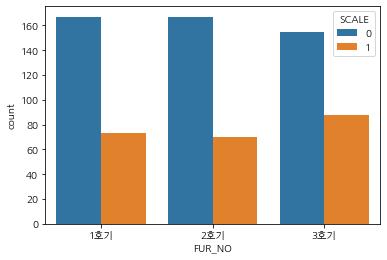

In [14]:
sns.countplot(data = df_raw, x = df_raw['FUR_NO'], hue = df_raw['SCALE'])
plt.show()

**가열로 호기에 따른 분류는 양품판정에 영향X**

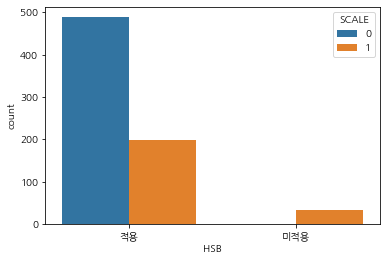

In [15]:
sns.countplot(data = df_raw, x = df_raw['HSB'], hue = df_raw['SCALE'])
plt.show()

**HSB는 이미 SCALE이 발생한 데이터에 대해 설명하는 변수이기에 삭제**

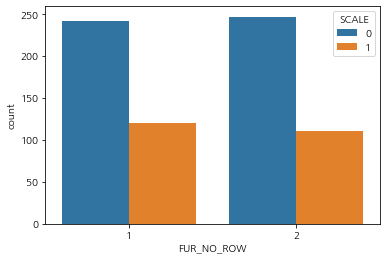

In [16]:
sns.countplot(data = df_raw, x = df_raw['FUR_NO_ROW'], hue = df_raw['SCALE'])
plt.show()

**작업 순번 또한 양품 판정에 영향X**

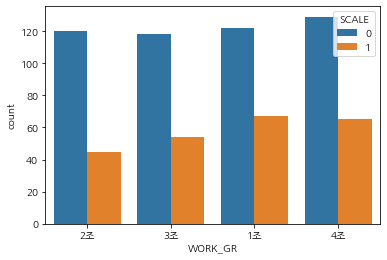

In [17]:
sns.countplot(data = df_raw, x = df_raw['WORK_GR'], hue = df_raw['SCALE'])
plt.show()

**작업조에 따른 분류는 양품판정에 영향X**

## 모델 학습

### 데이터 분리 및 Scaling

In [18]:
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934.0,적용,8,2조
1,PB562775,2008-08-01:00:00:16,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937.0,적용,8,2조
2,PB562776,2008-08-01:00:00:59,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889.0,적용,8,3조
3,PB562777,2008-08-01:00:01:24,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885.0,적용,8,3조
4,PB562778,2008-08-01:00:01:44,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873.0,적용,8,1조


In [19]:
df_raw.drop(["PLATE_NO", "ROLLING_DATE", "SPEC", "FUR_NO", "HSB", "STEEL_KIND"], axis=1, inplace=True)

In [20]:
df_char = df_raw.select_dtypes(include = "object")
df_numeric = df_raw.select_dtypes(exclude = "object")

In [25]:
# drop: X변수외 변수 삭제
df_raw_x = df_raw.drop(["SCALE"], axis = 1, inplace = False)

# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw_x)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,32.25,3707,15109,14180,1,1144,116,1133,59,282,1125,934.0,8,0,1,0,0
1,32.25,3707,15109,14180,2,1144,122,1135,53,283,1120,937.0,8,0,1,0,0
2,33.27,3619,19181,18130,1,1129,116,1121,55,282,1106,889.0,8,0,0,1,0
3,33.27,3619,19181,18130,2,1152,125,1127,68,316,1113,885.0,8,0,0,1,0
4,38.33,3098,13334,12430,1,1140,134,1128,48,314,1118,873.0,8,1,0,0,0


In [26]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

NameError: name 'df_raw_y' is not defined

In [27]:
# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_char],axis = 1)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,WORK_GR
0,-0.687308,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.767342,-0.949149,-0.626453,-0.409268,-0.816535,-0.117621,-0.19693,2조
1,-0.687308,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.932981,-0.835252,-0.856618,-0.387221,-1.096730,-0.071816,-0.19693,2조
2,-0.687308,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.767342,-1.632537,-0.779897,-0.409268,-1.881276,-0.804705,-0.19693,3조
3,-0.687308,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,1.015800,-1.290843,-0.281206,0.340311,-1.489003,-0.865779,-0.19693,3조
4,-0.687308,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.264257,-1.233894,-1.048422,0.296219,-1.208808,-1.049002,-0.19693,1조


In [28]:
# SCALE 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled["SCALE"] = np.where(df_scaled["SCALE"]> 0, 1, 0)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING,WORK_GR
0,0,0.155812,1.738951,-1.390441,-1.103810,-0.994460,-0.543782,0.767342,-0.949149,-0.626453,-0.409268,-0.816535,-0.117621,-0.19693,2조
1,0,0.155812,1.738951,-1.390441,-1.103810,1.005571,-0.543782,0.932981,-0.835252,-0.856618,-0.387221,-1.096730,-0.071816,-0.19693,2조
2,0,0.209106,1.568896,-1.095771,-0.944112,-0.994460,-1.263141,0.767342,-1.632537,-0.779897,-0.409268,-1.881276,-0.804705,-0.19693,3조
3,0,0.209106,1.568896,-1.095771,-0.944112,1.005571,-0.160124,1.015800,-1.290843,-0.281206,0.340311,-1.489003,-0.865779,-0.19693,3조
4,0,0.473482,0.562094,-1.518889,-1.174562,-0.994460,-0.735611,1.264257,-1.233894,-1.048422,0.296219,-1.208808,-1.049002,-0.19693,1조


In [29]:
# 데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled, # 데이터
                                                   test_size = 0.3, # test 데이터의 비율
                                                   random_state = 1234)  # random state

#### 상관계수 및 Heatmap

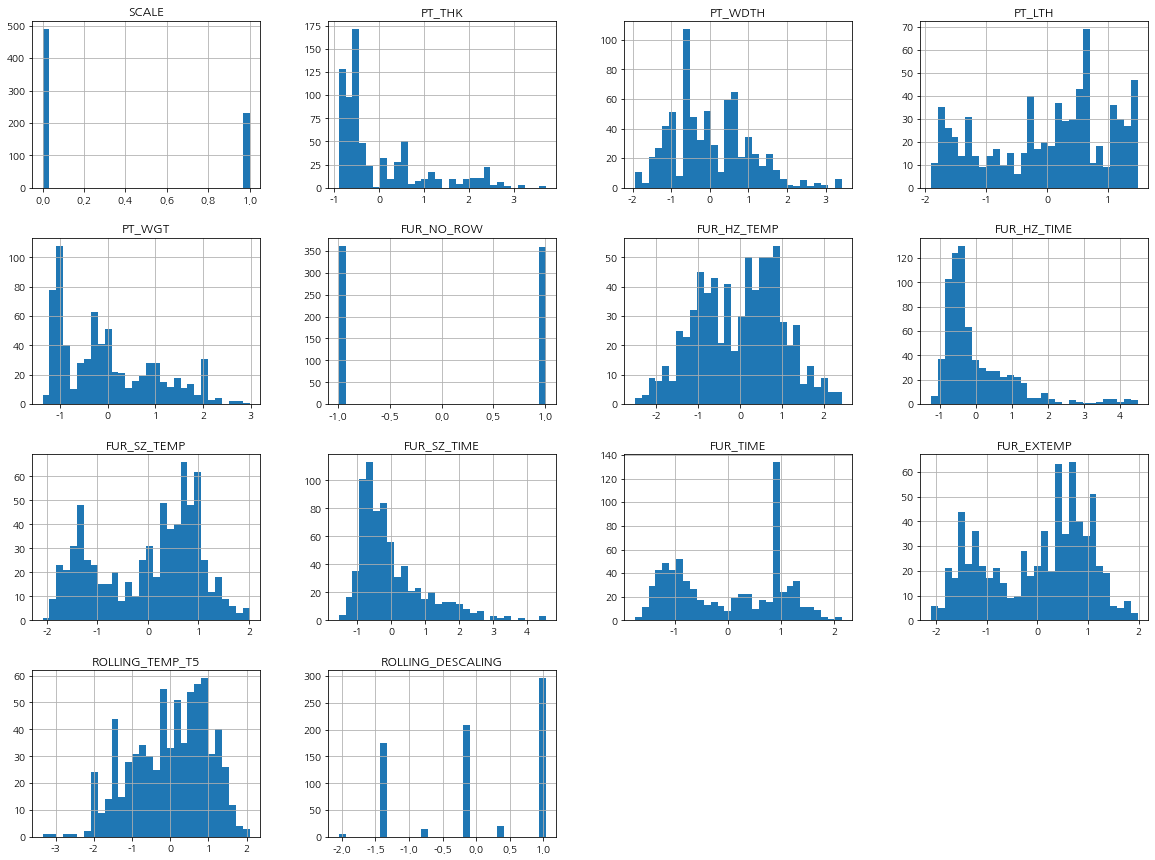

In [30]:
df_scaled.hist(bins=30, figsize=(20, 15))
plt.show()

In [31]:
df_train = pd.concat((df_scaled, df_obj), axis=1)
df_train

NameError: name 'df_obj' is not defined

In [32]:
df_scaled.corr()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,1.000000,-0.124858,-0.206021,0.100475,0.218741,-0.022960,0.247670,0.064466,0.374809,-0.255138,-0.049214,0.374679,0.551898,-0.006955
PT_THK,-0.124858,1.000000,-0.313151,-0.862618,-0.397391,-0.002530,-0.523926,0.171835,-0.694770,0.269365,0.413009,-0.687565,-0.497441,-0.836631
PT_WDTH,-0.206021,-0.313151,1.000000,0.119726,0.031009,0.006727,0.180024,-0.126002,0.227296,-0.051361,-0.393200,0.216078,-0.111239,0.337540
PT_LTH,0.100475,-0.862618,0.119726,1.000000,0.451815,-0.021185,0.473111,-0.090338,0.645402,-0.230159,-0.251950,0.641330,0.432096,0.809280
PT_WGT,0.218741,-0.397391,0.031009,0.451815,1.000000,-0.022241,0.153331,0.007292,0.359513,-0.193112,-0.057776,0.361377,0.419302,0.238986
FUR_NO_ROW,-0.022960,-0.002530,0.006727,-0.021185,-0.022241,1.000000,0.004753,-0.007522,0.009228,0.062408,0.016053,0.013799,-0.006536,0.018219
FUR_HZ_TEMP,0.247670,-0.523926,0.180024,0.473111,0.153331,0.004753,1.000000,-0.112438,0.772907,-0.327912,-0.348223,0.758185,0.354927,0.470899
FUR_HZ_TIME,0.064466,0.171835,-0.126002,-0.090338,0.007292,-0.007522,-0.112438,1.000000,-0.210175,0.067994,0.483407,-0.196404,0.004005,-0.152363
FUR_SZ_TEMP,0.374809,-0.694770,0.227296,0.645402,0.359513,0.009228,0.772907,-0.210175,1.000000,-0.566177,-0.477177,0.985245,0.657534,0.648646
FUR_SZ_TIME,-0.255138,0.269365,-0.051361,-0.230159,-0.193112,0.062408,-0.327912,0.067994,-0.566177,1.000000,0.490728,-0.565912,-0.478913,-0.285524


In [ ]:
fig = plt.figure(figsize = (12, 8))
sns.heatmap(df_scaled.corr(), annot=True, cmap='Pastel1')
plt.show()

PT_THICK랑 ROLLING_DESCALING의 음의 상관계수가 높다.
PT_LENGTH랑 ROLLING_DESCALING의 양의 상관계수가 높다.
PT_THICK랑 PT_LENGTH랑 음의 상관계수가 높다.

DESCALING은 고압수로 scale을 제거하는 것 => 길이가 길거나 두께가 얇을수록 DESCALING이 증가
길이가 길거나 두께가 얇을수록 양품판정에 영향을 미칠 수 있다.

FUR_SZ_TEMP와 FUR_EXTEMP의 상관계수가 1에 가까우므로 선형성을 지닌다고 볼 수 있다.
    => 따라서 두 변수 중 FUR_SZ_TEMP를 삭제한다.

### Logistic Regression

In [ ]:
df_scaled.head()

In [ ]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula('SCALE ~ PT_THK+PT_WDTH+PT_LTH+PT_WGT+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+FUR_EXTEMP+ROLLING_TEMP_T5+ROLLING_DESCALING+C(WORK_GR)', df_scaled_train)
# 적합
scaled_log_result = log_model.fit()
# 결과 출력
print(scaled_log_result.summary())

In [ ]:
# 실제 test 데이터의 목표변수와 test 데이터의 예측값 비교y_pred = log_result.predict(df_test)
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"], y_pred_class)))

### Decision Tree

In [ ]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# 훈련 데이터 정확도
print("Accucary on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = max_depth, random_state = 1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

#### <span style="color:green">최대 깊이 변경 결과</span>
- Depth 5일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=5, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

#### <span style="color:green">잎사귀 노드 최소 자료 수 변경 결과</span>
- Leaf가 10일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 20 for n_split in range(1, 11)]

for min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split, min_samples_leaf = 10, max_depth = 5, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

#### <span style="color:green">분리 노드 최소 자료 수 변경 결과</span>
- Split 80일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

#### <span style="color:red">Hyper Parameter 변경 결과</span>
- Leaf : 10
- Split : 80
- Depth : 5

In [ ]:
tree_final = DecisionTreeClassifier(max_depth = 5, min_samples_split=80, min_samples_leaf = 10)
tree_final.fit(df_train_x, df_train_y)

# 평가
y_pred = tree_final.predict(df_test_x)
print("Score on training set : {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

In [ ]:
# 최종 의사결정 트리 시각화
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=11, max_depth=5, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

In [ ]:
df_importance.sort_values("Importance", ascending=True,inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

#### <span style="color:red">Decision Tree 결론</span>
- 앞서 확인한 Leaf = 10, Split = 80, Depth = 5로 최종 모델을 학습시킨 결과 다음과 같은 score를 얻을 수 있었다.
    - TRAINING SCORE : 91.9%, TEST SCORE : 92.6%
- 또한 변수 중요도를 살펴본 결과 ROLLING_TEMP_T5, FUR_SZ_TEMP의 항목에 따라 결과값이 영향을 받는다는 것을 알 수 있었다.

### Random Forest

In [ ]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
print("Accuracy on training : {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

In [ ]:
train_accuracy = []
test_accuracy = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

df_accuracy_n.round(3)

In [ ]:
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label="Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label="Test Accuracy")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.legend()

#### <span style="color:green">트리 수 변경 결과</span>
- Estimators가 30일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
oob_error = []

for v_n_estimator in range(1, 151):
    rf = RandomForestClassifier(n_estimators=v_n_estimator, oob_score=True, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

In [ ]:
plt.plot(range(1, 151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

In [ ]:
train_accuracy = []
test_accuracy = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth=v_max_depth, n_estimators = 30, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

df_accuracy_depth.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

#### <span style="color:green">최대 깊이 변경 결과</span>
- depth 5일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
train_accuracy = []
test_accuracy = []

para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split=v_min_samples_split, max_depth=5, n_estimators = 30, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

df_accuracy_split.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split")
plt.ylabel("accuracy")
plt.legend()

#### <span style="color:green">분리 노드 최소 자료 수 변경 결과</span>
- Split 10일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
train_accuracy = []
test_accuracy = []

para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf=v_min_samples_leaf, max_depth=5, min_samples_split=10, n_estimators = 30, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesLeaf"] = para_leaf
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

df_accuracy_split.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples lㅠeaf")
plt.ylabel("accuracy")
plt.legend()

#### <span style="color:green">잎사귀 노드 최소 자료 수 변경 결과</span>
- Leaf 10일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

#### <span style="color:red">Hyper Parameter 변경 결과</span>
- Estimators : 30
- Leaf : 10
- Split : 10
- Depth : 5

In [ ]:
rf_final = RandomForestClassifier(min_samples_leaf=10, min_samples_split=10, max_depth=5, n_estimators = 30, random_state=1234)
rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

print("Accuracy on training set : {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion matrix : \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

In [ ]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

In [ ]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [ ]:
# 최종 의사결정 트리 시각화
v_feature_name = df_train_x.columns
export_graphviz(rf_final.estimators_[0], out_file="rf_final_0.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("rf_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### <span style="color:red">Random Forest 결론</span>
- 앞서 확인한 Estimators = 30, Leaf = 10, Split = 10, Depth = 5로 최종 모델을 학습시킨 결과 다음과 같은 score를 얻을 수 있었다.
    - TRAINING SCORE : 90.7%, TEST SCORE : 91.5%
- 또한 변수 중요도를 살펴본 결과 ROLLING_DESCALING, FUR_EXTEMP, PT_THK, FUR_SZ_TEMP 등의 항목에 따라 결과값이 영향을 받는다는 것을 알 수 있었다.

### Gradient Boosting

In [ ]:
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
print("Accuracy on training : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

In [ ]:
train_accuracy = []
test_accuracy = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators=v_n_estimators, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

df_accuracy_n.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("Estimators")
plt.ylabel("accuracy")
plt.legend()

#### <span style="color:green">트리 수 변경 결과</span>
- Estimators가 50일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
train_accuracy = []
test_accuracy = []

para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf=v_min_samples_leaf, n_estimators = 50, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

df_accuracy_leaf.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples leaf")
plt.ylabel("accuracy")
plt.legend()

#### <span style="color:green">잎사귀 노드 최소 자료 수 변경 결과</span>
- Leaf가 10일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
train_accuracy = []
test_accuracy = []

para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split=v_min_samples_split, min_samples_leaf=10, n_estimators = 50, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

df_accuracy_split.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split")
plt.ylabel("accuracy")
plt.legend()

#### <span style="color:green">분리 노드 최소 자료 수 변경 결과</span>
- Split가 10일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
train_accuracy = []
test_accuracy = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=v_max_depth, n_estimators = 50, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

df_accuracy_depth.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

#### <span style="color:green">최대 깊이 변경 결과</span>
- Depth가 4일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
train_accuracy = []
test_accuracy = []

para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate=v_learning_rate,random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

df_accuracy_lr.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

#### <span style="color:green">학습률 변경 결과</span>
- Learning Rate가 0.1일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

#### <span style="color:red">Hyper Parameter 변경 결과</span>
- Estimators : 50
- Leaf : 10
- Split : 10
- Depth : 4
- Learning Rate = 0.1

In [ ]:
gb_final = GradientBoostingClassifier(min_samples_leaf=10, min_samples_split=10, learning_rate=0.1, max_depth=4, n_estimators = 50, random_state=1234)
gb_final.fit(df_train_x, df_train_y)
y_pred = gb_final.predict(df_test_x)

print("Accuracy on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))
print("Confusion matrix : \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

In [ ]:
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

In [ ]:
df_importance.sort_values("Importance", ascending=True,inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

#### <span style="color:red">Gradient Boosting 결론</span>
- 앞서 확인한 Estimators = 50, Leaf = 10, Split = 10, Depth = 4, LearningRate = 0.1로 최종 모델을 학습시킨 결과 다음과 같은 score를 얻을 수 있었다.
    - TRAINING SCORE : 96.4%, TEST SCORE : 94.9%
- 또한 변수 중요도를 살펴본 결과 ROLLING_TEMP_T5, FUR_SZ_TEMP의 항목에 따라 결과값이 영향을 받는다는 것을 알 수 있었다.

### Neural Network

In [ ]:
nm_uncustomized = MLPClassifier(random_state = 1234)
nm_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(nm_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(nm_uncustomized.score(df_test_x, df_test_y)))

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_hidden = [20 * hidden for hidden in range(1, 20)]

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes=(v_hidden, v_hidden), random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy

df_accuracy_hidden.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("HiddenLayer")
plt.legend()
hidden_layer_sizes = 200

#### <span style="color:green">Hidden 변경 결과</span>
- Hidden 200일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_function = ["logistic", "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation=v_function, hidden_layer_sizes=(200, 200), random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_function = pd.DataFrame()
df_accuracy_function["ActivationFunction"] = para_function
df_accuracy_function["TrainAccuracy"] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy

df_accuracy_function.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_function, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("ActivationFunction")
plt.legend()
activation = 'relu'

#### <span style="color:green">Function 변경 결과</span>
- Function relu일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_solver = ["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn = MLPClassifier(solver=v_solver, activation="relu", hidden_layer_sizes=(200, 200), random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver["TrainAccuracy"] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy

df_accuracy_solver.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_solver, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_solver, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("Solver")
plt.legend()
solver = 'adam'

#### <span style="color:green">Solver 변경 결과</span>
- Solver adam일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

para_batch = [20 * batch for batch in range(1, 10)]

for v_batch in para_batch:
    nn = MLPClassifier(batch_size=v_batch, solver="adam", activation = "relu", hidden_layer_sizes=(200, 200), random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["MiniBatch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy

df_accuracy_batch.round(3)

In [ ]:
# 정확도를 그래프로 표현
plt.plot(para_batch, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("Miny Batch Size")
plt.legend()
minibatch = 20

#### <span style="color:green">Batch 변경 결과</span>
- Batch 20일 때, TrainScore와 TestScore의 차이가 가장 적으며, 두 수 다 큰 값을 갖는다.

In [ ]:
nn_final = MLPClassifier(hidden_layer_sizes=(200, 200), activation="relu", \
                        solver='adam', batch_size = 20, random_state=1234)
nn_final.fit(df_train_x, df_train_y)
y_pred = nn_final.predict(df_test_x)

# train 데이터 셋 정확도
print("train data accuracy: {0:.3f}".format(nn_final.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("test data accuracy: {0:.3f}\n".format(nn_final.score(df_test_x, df_test_y)))

# confusion matrix"
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

print(classification_report(df_test_y, y_pred, digits=3))

#### <span style="color:red">Neural Network 결론</span>
- 앞서 확인한 Hidden = 200, Activation Fucntion = relu, Solver = adam, Batch = 20으로 최종 모델을 학습시킨 결과 다음과 같은 score를 얻을 수 있었다.
    - TRAINING SCORE : 69.2%, TEST SCORE : 68.1%
- 또한 변수 중요도를 살펴본 결과 ROLLING_TEMP_T5, FUR_SZ_TEMP의 항목에 따라 결과값이 영향을 받는다는 것을 알 수 있었다.

## 최종 모델 도출
- Decision Tree : 92.6%
- Random Forest : 91.5%
- Gradient Boosting : 94.9%
- Neural Network : 68.1%

=> Gradient Boosting 기법을 통해 학습시킨 모델의 Test Accuracy가 가장 높았다.  
=> 따라서 Scale을 분류하기에 적합한 모델은 "Gradient Boosting" 이다.

# <span style='color:blue'>결과 도출</span>
=> Gradient Boosting 기법을 통해 학습시킨 모델의 Test Accuracy가 가장 높았다.  
=> 따라서 Scale을 분류하기에 적합한 모델은 "Gradient Boosting" 이다.
- Gradient Boosting 기법을 통해 변수의 중요도를 산출한 결과, Scale 양품판정에 영향을 주는 변수는 ROLLING_TEMP_T5, FUR_SZ_TEMP 순이다.